# Clustering: Comparaison des résultats 

Un regroupement des caractéristiques obtenues est effectué sur une collection d'images définie par (n1,n2).
La collection d'images utilisée est "aloi_red4_view" (72 images par objet).
On va utiliser les caractéristiques de couleurs et de texture.

Number of objects= 10
Number of images= 720
Number of features= 179


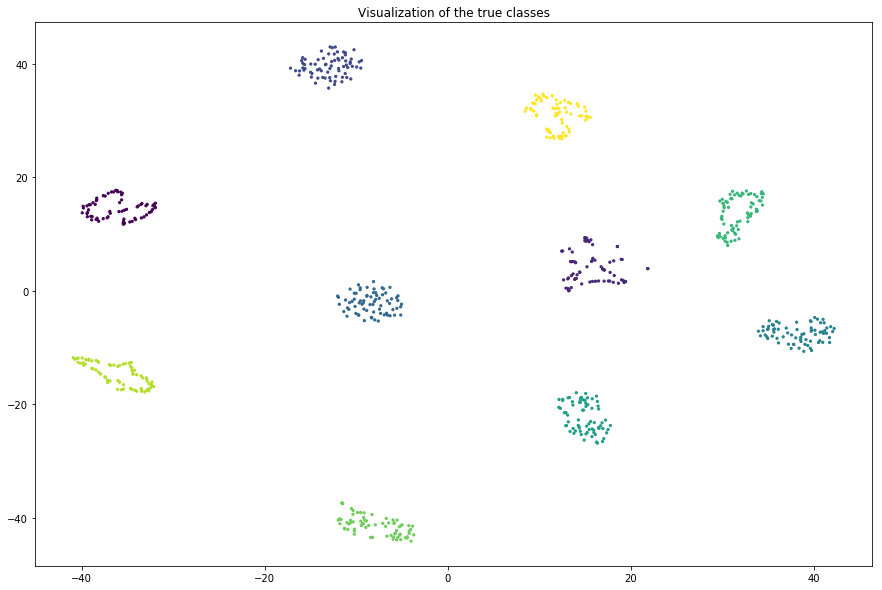

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from Image_reading import *
from Color_descriptors import *
from Shape_descriptors import concatShapeFeatures
from Texture_descriptors import lbp
    
#   Parameters defintion:
n1=1 # First Object (included)
n2=11 # Last Object (excluded)
n_img=72 # number of images per object

color_space='hsv'
bins=[4,4,4]
n_colors=8
n_fft=64
hist_size_lbp=100

classes_true=[]
for i in range(0,n2-n1):
    classes_true=classes_true+[i]*n_img
classes_true=np.array(classes_true)

#     First, we regroup the images features in a single 2D-Array where each line is the feature vector of an image
X_all=[]
for i in range(n_img*(n2-n1)):
    X_all.append([])
for i in range(n2-n1):
    for j in range(n_img):
        X=read_image_2(i+n1,j)

        # *********************************************************
        # ********************Color_features***********************
        # *********************************************************
        # *********************Color_moments***********************
        moments_ftr=moments_calcul(X,color_space)
        X_all[n_img*i+j]=X_all[n_img*i+j]+[moments_ftr]
        # *********************Color_histogram*********************
        hist= color_histogram(X,color_space,bins)
        X_all[n_img*i+j]=X_all[n_img*i+j]+[hist]

        """
        # *********************************************************
        # ********************Shape_features***********************
        # *********************************************************
        shape_ftr=concatShapeFeatures(X,n_fft)
        X_all[n_img*i+j]=X_all[n_img*i+j]+[shape_ftr]
        """
        # *********************************************************
        # ********************Texture_features*********************
        # *********************************************************
        lbp_feature=lbp(X,hist_size_lbp)
        X_all[n_img*i+j]=X_all[n_img*i+j]+[lbp_feature]

        X_all[n_img*i+j]=np.concatenate(X_all[n_img*i+j])

X_all=np.array(X_all).astype(float)
print("Number of objects= "+ str(n2-n1))
print("Number of images= "+ str(X_all.shape[0]))
print("Number of features= "+ str(X_all.shape[1]))

# ************Visualization_before_clustering******************
X_norm = StandardScaler().fit_transform(X_all)
X_embedded = TSNE(n_components=2).fit_transform(X_norm)

plt.figure(figsize=(15,10))
plt.scatter(X_embedded[:,0],X_embedded[:,1],c=classes_true,s=5)
plt.title("Visualization of the true classes")
plt.show()

On enregistre la matrice des caractéristiques pour pouvoir l'utiliser plus rapidement.

In [4]:
X=np.hstack((X_norm,classes_true[:,np.newaxis]))
np.random.shuffle(X)
np.save("feature_matrix_1",X)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.manifold import TSNE

## Kmeans

On va d'abord utiliser l'algorithme du clustering est le k-means  (implémenté à l'aide de la scikitlearn) avec une distance euclidienne.
Les résultats sont évalués à l'aide de métriques comme l'adjusted rand score.

**************Clustering_results*********************
Number of clusters= 10
adjusted_rand_score=0.74
homogeneity_score=0.86
completeness_score=0.92
v_measure_score=0.89
fowlkes_mallows_score=0.77


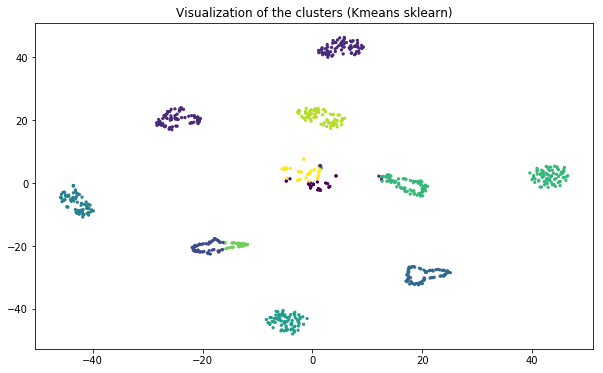

In [6]:
from KMeans_Clustering import kmeans_clustering_sklearn

X = np.load("feature_matrix_1.npy")
classes_true = X[:,-1]
X = X[:,:-1]
# ********************Clustering************************
n_clusters_ = 10 # number of objects
classes, inertia = kmeans_clustering_sklearn(X,n_clusters_)

print("**************Clustering_results*********************")
print("Number of clusters= "+str(max(classes)+1))
print('adjusted_rand_score=%0.2f' % metrics.adjusted_rand_score(classes_true,classes))
print('homogeneity_score=%0.2f' % metrics.homogeneity_score(classes_true,classes))
print('completeness_score=%0.2f' % metrics.completeness_score(classes_true,classes))
print('v_measure_score=%0.2f' % metrics.v_measure_score(classes_true,classes))
print('fowlkes_mallows_score=%0.2f' % metrics.fowlkes_mallows_score(classes_true,classes))

# ************Visualization_after_clustering******************
X_embedded = TSNE(n_components=2).fit_transform(X)
plt.figure(figsize=(10,6))
plt.scatter(X_embedded[:,0],X_embedded[:,1],c=classes,s=5)
plt.title("Visualization of the clusters (Kmeans sklearn)")
plt.show()

On remarque qu'en combinant tous les descripteurs, on arrive bien séparer les images par objet (figure 1: Visualization of the true classes). Mais on remarque que l'algorithme k-means n'arrive pas à bien identifier les bons clusters (figure 2: Visualization of the clusters): On obtient un score de l'ordre de 75%.

#### Choix du nombre de clusters :
On a choisi dans l'exemple précédent le nombre de clusters égal à 10 parce qu'on connaît le nombre d'objets en question et qu'on veut séparer les images selon l'identité de l'objet observé. Mais imaginons qu'on ne connaît pas justement cette donnée, c'est-à-dire que les images ne sont pas labelisées. En réalité, le but d'un algorithme de clustering, c'est qu'on peut l'appliquer à des images non labelisées pour les classer dans des clusters, d'où la nécessité de chercher les paramètres optimaux pour la méthode de clustering (ici le nombre de clusters) sans connaissance a priori des classes des images.

On va regarder alors une métrique qui permet d'estimer la qualité d'un clustering (pour différent choix du nombre de clusters) à partir de la structure des données, et non à partir de leurs vraies classes. On regardera ensuite si l'estimation avec cette métrique correspond bien avec la valeur optimale du nombre de clusters.

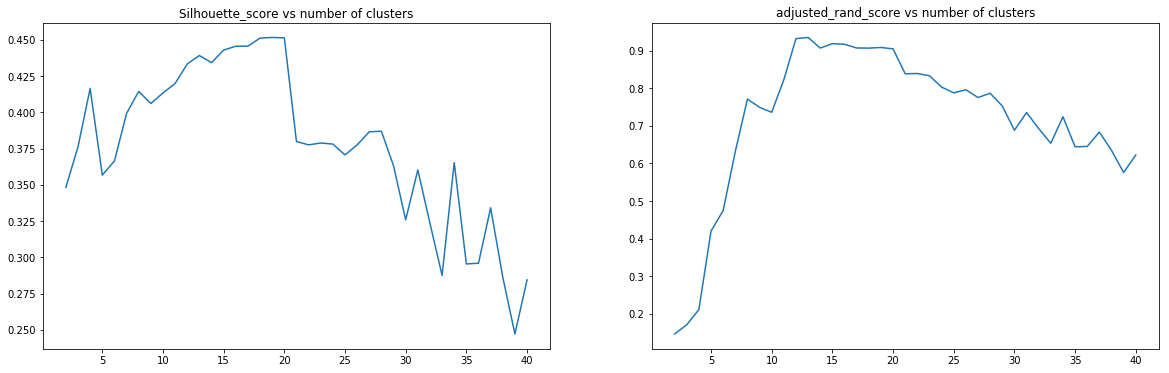

In [9]:
from KMeans_Clustering import kmeans_clustering_sklearn

X=np.load("feature_matrix_1.npy")
classes_true=X[:,-1]
X=X[:,:-1]
# ********************Clustering************************
adjusted_rand_score = []
silhouette_score_list = []
n_clusters_max = 40
n_clusters_list = np.arange(n_clusters_max-1)+2

for k in n_clusters_list:
    classes, inertia = kmeans_clustering_sklearn(X, k)
    
    adjusted_rand_score.append(metrics.adjusted_rand_score(classes_true,classes))
    silhouette_score_list.append(metrics.silhouette_score(X,classes))
    
plt.figure(figsize=(20,6))
ax1 = plt.subplot(1,2,1)
ax1.plot(n_clusters_list, silhouette_score_list)
ax1.set_title("Silhouette_score vs number of clusters")
ax2 = plt.subplot(1,2,2)
ax2.plot(n_clusters_list, adjusted_rand_score)
ax2.set_title("adjusted_rand_score vs number of clusters")
plt.show()

On remarque d'abord dans la figure à droite que le choix n_clusters=10 effectué précedemment n'est pas optimal dans la situation étudiée (choix des caractéristiques, méthode de clustering, distance euclidienne ...). 
On remarque aussi que la valeur optimale donnée par le silhouette score n'est pas la même que celle donnée par l'adjusted rand score. Mais on observe que les deux courbes ont pratiquement des formes comparables (une croissance entre 2 et 10, une stabilité entre 10 et 20 et une décroissance entre 20 et 40) et on voit qu'un choix effectué à partir de la courbe silhouette_score (n_clusters_optimal=20) ne déterioire pas les résultats au niveau de l'adjusted_rand_score. Cette observation donne de l'intérêt à la silhouette_score parce qu'elle montre qu'il permet d'estimer le nombre de clusters sans connaître prioro les vraies classes.

#### Défintion de la distance: 
On va maintenant utiliser d'autres défintions de distance (en fixant le nombre de classes à 10). Comme l'outil sklearn n'offre pas la possibilité de modifier la distance, on va se servir d'une autre implémentation du kmeans qui permet de le faire manuellement. D'abord, on teste cette implémentation avec le même type de distance (euclidienne).

In [ ]:
from KMeans_Clustering import kmeans_pp

X=np.load("feature_matrix_1.npy")
classes_true=X[:,-1]
X=X[:,:-1]

# ********************Clustering************************
# Distance choice: euclidean, ...
n_clusters_=10 # number of objects
classes=kmeans_pp(X,n_clusters_,"euclidean",n_init=5)

print("**************Clustering_results*********************")
print("Number of clusters= "+str(max(classes)+1))
print('adjusted_rand_score=%0.2f' % metrics.adjusted_rand_score(classes_true,classes))
print('homogeneity_score=%0.2f' % metrics.homogeneity_score(classes_true,classes))
print('completeness_score=%0.2f' % metrics.completeness_score(classes_true,classes))
print('v_measure_score=%0.2f' % metrics.v_measure_score(classes_true,classes))
print('fowlkes_mallows_score=%0.2f' % metrics.fowlkes_mallows_score(classes_true,classes))

# ************Visualization_after_clustering******************
X_embedded = TSNE(n_components=2).fit_transform(X)
plt.figure(figsize=(10,6))
plt.scatter(X_embedded[:,0],X_embedded[:,1],c=classes,s=5)
plt.title("Visualization of the clusters (Kmeans pp)")
plt.show()

10 3.769283549052367 {0: 74.0, 1: 49.0, 2: 75.0, 3: 23.0, 4: 51.0, 5: 152.0, 6: 72.0, 7: 140.0, 8: 12.0, 9: 72.0}
**************Clustering_results*********************
Number of clusters= 10.0
adjusted_rand_score=0.73
homogeneity_score=0.85
completeness_score=0.92
v_measure_score=0.88
fowlkes_mallows_score=0.77


On remarque que l'implémentation proposée donne des résultats comparables avec ceux de scikit-learn. On va continuer à travailler avec la 2ème implémentation pour tester plusieurs types de distances.

In [12]:
from KMeans_Clustering import kmeans_pp

X=np.load("feature_matrix_1.npy")
classes_true=X[:,-1]
X=X[:,:-1]
# ********************Clustering************************
n_clusters_=10 # number of objects
distance=["euclidean","manhattan","chebyshev","cosine","correlation","braycurtis","canberra"]
adjusted_rand_score=[]

for dist_type in distance:
    print(dist_type)
    classes=kmeans_pp(X, n_clusters_, dist_type, n_init=5)
    adjusted_rand_score.append(metrics.adjusted_rand_score(classes_true,classes))

euclidean
10 3.6611176352886736 {0: 49.0, 1: 151.0, 2: 72.0, 3: 72.0, 4: 72.0, 5: 64.0, 6: 73.0, 7: 72.0, 8: 72.0, 9: 23.0}
manhattan
10 17.608909368995405 {0: 33.0, 1: 23.0, 2: 72.0, 3: 49.0, 4: 153.0, 5: 72.0, 6: 72.0, 7: 139.0, 8: 72.0, 9: 35.0}
chebyshev
10 1.9571579975112567 {0: 165.0, 1: 72.0, 2: 72.0, 3: 64.0, 4: 51.0, 5: 53.0, 6: 140.0, 7: 72.0, 8: 21.0, 9: 10.0}
cosine
10 0.11021344424264817 {0: 72.0, 1: 149.0, 2: 72.0, 3: 27.0, 4: 72.0, 5: 72.0, 6: 67.0, 7: 72.0, 8: 45.0, 9: 72.0}
correlation
10 0.11222384328036535 {0: 72.0, 1: 72.0, 2: 149.0, 3: 72.0, 4: 72.0, 5: 71.0, 6: 72.0, 7: 72.0, 8: 44.0, 9: 24.0}
braycurtis
10 0.17233912135272744 {0: 74.0, 1: 72.0, 2: 72.0, 3: 136.0, 4: 72.0, 5: 35.0, 6: 72.0, 7: 72.0, 8: 34.0, 9: 81.0}
canberra
10 16.29345770017157 {0: 72.0, 1: 69.0, 2: 227.0, 3: 72.0, 4: 24.0, 5: 72.0, 6: 73.0, 7: 11.0, 8: 72.0, 9: 28.0}


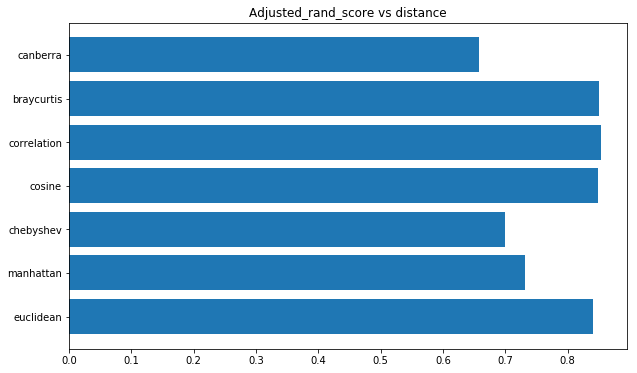

In [17]:
# ************Distance_comparison_kmeans******************
plt.figure(figsize=(10,6))
plt.barh(distance, adjusted_rand_score)
plt.title("Adjusted_rand_score vs distance")
plt.show()

On observe que l'utilisation de certaines distances (surtout les distances "cosine" et "correlation") permettent d'améliorer les résultats.

## DBSCAN

D'après les figures présentées précedemment, on remarque que les points sont regroupés par densité, ce qui nous oriente vers l'utilisation d'un clustering DBSCAN. Cet algorithme repose sur deux paramètres dont le choix est moins intuitif que celui du choix du nombre de clusters pour le kmeans.

Dans la littérature, les valeurs employées pour $minPts$ sont entre 3 et 8, ce qui donne 6 valeurs entiers à tester. La valeur d'$eps$ dépend de la structure des données et peut être estimée en utilisant un elbow graph.

Etant donné que DBSCAN est séquentiel et déterministe, on doit trouver pour toutes les exécutions d'un même clustering le même résultat, ce qui facilite la comparaison entre différents choix des paramètres.

On va d'abord regarde l'influence des paramètres sur le score. On fixe $minPts = 4$ et on fait varier $eps$.

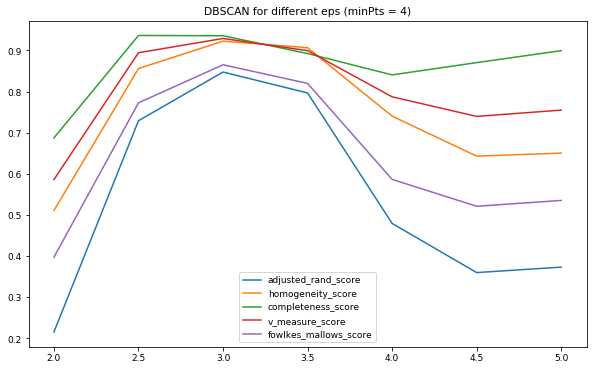

In [32]:
from DBSCAN_Clustering import dbscan_clustering_sklearn

X=np.load("feature_matrix_1.npy")
classes_true=X[:,-1]
X=X[:,:-1]
# ********************Clustering************************
eps_array=np.linspace(2,5,7)
minPts_=4
metric_="euclidean"

adjusted_rand_score=[]
homogeneity_score=[]
completeness_score=[]
v_measure_score=[]
fowlkes_mallows_score=[]

for eps_ in eps_array:
    classes=dbscan_clustering_sklearn(X,eps_,minPts_,metric_)
    adjusted_rand_score.append(metrics.adjusted_rand_score(classes_true,classes))
    homogeneity_score.append(metrics.homogeneity_score(classes_true,classes))
    completeness_score.append(metrics.completeness_score(classes_true,classes))
    v_measure_score.append(metrics.v_measure_score(classes_true,classes))
    fowlkes_mallows_score.append(metrics.fowlkes_mallows_score(classes_true,classes))
    
# ************DBSCAN (various eps)******************
plt.figure(figsize=(10,6))
plt.plot(eps_array, adjusted_rand_score,label="adjusted_rand_score")
plt.plot(eps_array, homogeneity_score, label="homogeneity_score")
plt.plot(eps_array, completeness_score, label="completeness_score")
plt.plot(eps_array, v_measure_score, label="v_measure_score")
plt.plot(eps_array, fowlkes_mallows_score, label="fowlkes_mallows_score")
plt.title("DBSCAN for different eps (minPts = 4)")
plt.legend()
plt.show()

On remarque que le score varie beaucoup en fonction d'$eps$. C'est donc un paramètre important qu'on doit optimiser.

On fixe maintenant $eps = 3$ et on fait varier $minPts$.  

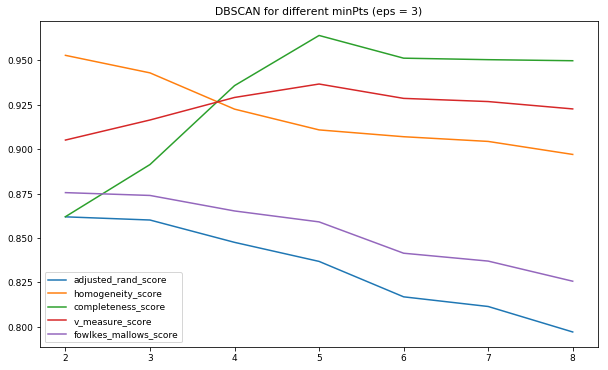

In [30]:
from DBSCAN_Clustering import dbscan_clustering_sklearn

X=np.load("feature_matrix_1.npy")
classes_true=X[:,-1]
X=X[:,:-1]
# ********************Clustering************************
eps_=3
minPts_array=np.linspace(2,8,7)
metric_="euclidean"

adjusted_rand_score=[]
homogeneity_score=[]
completeness_score=[]
v_measure_score=[]
fowlkes_mallows_score=[]

for minPts_ in minPts_array:
    classes=dbscan_clustering_sklearn(X,eps_,minPts_,metric_)
    adjusted_rand_score.append(metrics.adjusted_rand_score(classes_true,classes))
    homogeneity_score.append(metrics.homogeneity_score(classes_true,classes))
    completeness_score.append(metrics.completeness_score(classes_true,classes))
    v_measure_score.append(metrics.v_measure_score(classes_true,classes))
    fowlkes_mallows_score.append(metrics.fowlkes_mallows_score(classes_true,classes))
    
# ************DBSCAN (various minPts)******************
plt.figure(figsize=(10,6))
plt.plot(minPts_array, adjusted_rand_score,label="adjusted_rand_score")
plt.plot(minPts_array, homogeneity_score, label="homogeneity_score")
plt.plot(minPts_array, completeness_score, label="completeness_score")
plt.plot(minPts_array, v_measure_score, label="v_measure_score")
plt.plot(minPts_array, fowlkes_mallows_score, label="fowlkes_mallows_score")
plt.title("DBSCAN for different minPts (eps = 3)")
plt.legend()
plt.show()

On remarque que le score varie très peu en fonction de $minPts$ et décroît légèrement lorsque $minPts$ augmente. On choisira $minPts=3$ pour toute la suite et on employera la méthode de l'elbow graph pour fixer une valeur pour $eps$.

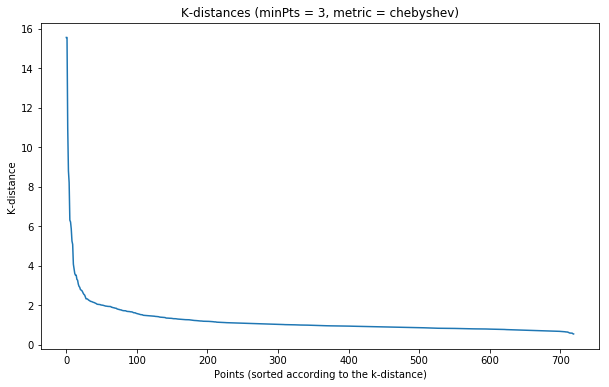

In [31]:
from K_distance_computation import K_distance

X = np.load("feature_matrix_1.npy")
minPts_ = 3
metric_ = "chebyshev"
# ["euclidean","manhattan","chebyshev","cosine","correlation","braycurtis","canberra"]
Knd = K_distance(X, minPts_, metric_)

plt.figure(figsize=(10,6))
plt.plot(Knd)
plt.title("K-distances (minPts = "+str(minPts_)+", metric = "+metric_+")")
plt.xlabel("Points (sorted according to the k-distance)")
plt.ylabel("K-distance")
plt.show()

On remarque un palier au niveau de k-distance = 3. Ceci peut être un critère pour choisir $eps$ lorsqu'on ne connaît pas les vraies classes (ce qui est toujours le cas en apprentissage non supervisé). 

Pour tester différentes distances, il suffit d'utiliser l'implémentation de scikit-learn qui offre de changer la métrique pour l'algorithme DBSCAN. On va garder $minPts = 3$ mais comme la recherche d'$eps$ dépend de la métrique choisie (car le calcul des k-distances utilise directement la matrice des distances), on va choisir pour chaque distance l'$eps$ approprié en utilisant l'elbow graph. Pour cela il suffit de changer le paramètre $metric$ et de regarder chaque fois où se situe le palier. Les valeurs trouvées ont été relevées dans eps_array.

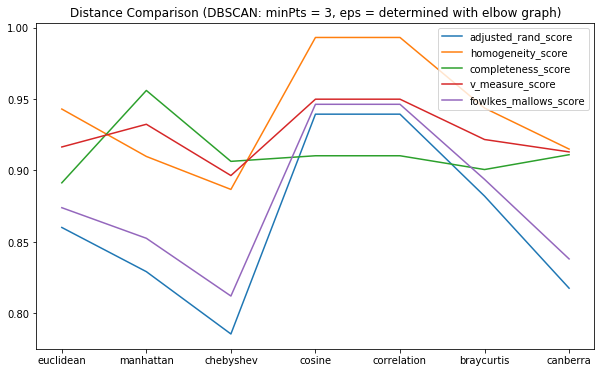

In [35]:
from DBSCAN_Clustering import dbscan_clustering_sklearn

X=np.load("feature_matrix_1.npy")
classes_true=X[:,-1]
X=X[:,:-1]
# ********************Clustering************************
eps_array = np.array([3, 12, 1.2, 0.1, 0.1, 0.12, 14])
minPts_ = 3
distance=["euclidean","manhattan","chebyshev","cosine","correlation","braycurtis","canberra"]
adjusted_rand_score=[]
homogeneity_score=[]
completeness_score=[]
v_measure_score=[]
fowlkes_mallows_score=[]

for k in range (len(distance)):
    classes=dbscan_clustering_sklearn(X,eps_array[k],minPts_,distance[k])
    adjusted_rand_score.append(metrics.adjusted_rand_score(classes_true,classes))
    homogeneity_score.append(metrics.homogeneity_score(classes_true,classes))
    completeness_score.append(metrics.completeness_score(classes_true,classes))
    v_measure_score.append(metrics.v_measure_score(classes_true,classes))
    fowlkes_mallows_score.append(metrics.fowlkes_mallows_score(classes_true,classes))
    
# ************Distance_comparison_kmeans******************
plt.figure(figsize=(10,6))
plt.plot(distance, adjusted_rand_score,label="adjusted_rand_score")
plt.plot(distance, homogeneity_score, label="homogeneity_score")
plt.plot(distance, completeness_score, label="completeness_score")
plt.plot(distance, v_measure_score, label="v_measure_score")
plt.plot(distance, fowlkes_mallows_score, label="fowlkes_mallows_score")
plt.title("Distance Comparison (DBSCAN: minPts = "+str(minPts_)+", eps = determined with elbow graph)")
plt.legend()
plt.show()

On remarque qu'on obtient des scores plus elevés que ceux pour le kmeans. Par contre, le choix des paramètres a été difficile et presque arbitraire (palier pas très visible dans l'elbow graph). 

Il est donc difficile de comparer les distances dans ce cas vu qu'on ne sait pas si les paramètres obtenus sont optimaux ou non, mais on remarque que les métriques "cosine" et "correlation" donne, comme pour le kmeans, les scores les plus élevés.